In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import os

In [3]:
# Extract variables

PATH_SOURCE = "/home/jbassham/jack/data/weddell/1992_2020"
PATH_DEST = PATH_SOURCE

In [4]:
fnam = "motion_ppv4_latlon_sh_1992_2020.npz"

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ui = data['u'] # zonal ice velocity
vi = data['v'] # meridional ice velocity
r = data['error']
lat = data['lat']
lon = data['lon']
time = data['time']

In [5]:
fnam = "con_nimbus7_latlon_sh_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ic = data['ic']# zonal ice velocity

# Mask ice concentration
ic_raw = np.round(ic * 250)

# Mask 
# 251 pole hole
# 252 unused data
# 253 coastline
# 254 land
ic = np.where((ic_raw == 251) | (ic_raw == 252) | (ic_raw == 253) | (ic_raw == 254), np.nan, ic)

In [6]:
fnam = "wind_JRA55_latlon_global_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
uw = data['u']
vw = data['v']

In [7]:
# Shift present day parameters forward one day, for one point Middle Weddell
uit = ui[1:,:,:]
vit = vi[1:,:,:]
uwt = uw[1:,:,:]
vwt = vw[1:,:,:]
ict = ic[1:,:,:]
tt = time[1:]
rt = r[1:,:,:]

# Remove last day from previous day parameters
icy = ic[:-1,:,:]
ty = time[:-1]

In [8]:
# Filter points with ice error greater than 999 and 0 concentration ice motion
# Create mask
mask = (ict == 0) | (np.isnan(ict)) | (rt >= 999) | (rt <= -999)

# NaN out points with above condition
uit = np.where(mask, np.nan, uit) 
uvt = np.where(mask, np.nan, vit)
rt = np.where(mask, np.nan, rt)
uwt = np.where(mask, np.nan, uwt)
vwt = np.where(mask, np.nan, vwt)
icy = np.where(mask, np.nan, icy)

In [9]:
# Flag uncerainty values less than 0.01, greater than 1000 as 9999
rt_flag = (np.where((rt <= 0.01 | rt >= 1000), 9999, rt)

In [10]:
def normalize(data):
    
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_norm = (data - data_mean)/data_std
    
    return data_norm

In [11]:
def weighted_skill(fit, true, r):
    
    skill_weighted = 1 - np.nanvar((true - fit) / r, axis = 0) / np.nanvar(true / r, axis = 0)
    
    return skill_weighted

In [12]:
def skill(fit, true, r):
    
    skill = 1 - np.nanvar(true - fit, axis = 0) / np.nanvar(true, axis = 0)
    # Check where true variance really small!
    
    return skill

### Unweighted LR

In [ ]:
# # Initialize arrays 
# u_fit_all = np.zeros((nt, ny, nx))
# v_fit_all = np.zeros((nt, ny, nx))

# u_true_all = np.full((nt, ny, nx), np.nan)
# v_true_all = np.full((nt, ny, nx), np.nan)

# skill_w_u = np.full((ny, nx), np.nan)
# skill_w_v = np.full((ny, nx), np.nan)
# skill_u = np.full((ny, nx), np.nan)
# skill_v = np.full((ny, nx), np.nan)


# m_all = np.zeros((3, ny, nx), dtype = complex)
        

# for iy in range(ny):
#     for ix in range(nx):

#         # Skip over land points (all nan)
#         if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
#             u_fit_all[:,iy,ix] = np.nan
#             v_fit_all[:,iy,ix] = np.nan
#             u_true_all[:,iy,ix] = np.nan
#             v_true_all[:,iy,ix] = np.nan
#             m_all[:,iy,ix] = np.nan
            
#         else:
#             try:
                
#                 # Create mask for valid values

#                 # Initialize mask shape of grid to true boolean (1 = True = Inclusion)
#                 true_mask = np.ones_like(uit[:,iy,ix], dtype=bool)

#                 # Set 'True' for indices with nan values, 'False' for valid
#                 inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

#                 # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
#                 true_mask = ~inan

#                 # Filter Ice Motion to true indices
#                 uit_f = uit[true_mask, iy, ix]
#                 vit_f = vit[true_mask, iy, ix]

#                 # Take Wind, Concentration, Uncertainty, time at same indices
#                 uwt_f = uwt[true_mask, iy, ix]
#                 vwt_f = vwt[true_mask, iy, ix]

#                 icy_f = icy[true_mask, iy, ix]

#                 rt_f = rt[true_mask, iy, ix]

#                 # Normalize data

#                 uit_n = normalize(uit_f)
#                 vit_n = normalize(vit_f)
#                 uwt_n = normalize(uwt_f)
#                 vwt_n = normalize(vwt_f)
                
#                 # Save normalized 'true' values
#                 u_true_all[true_mask, iy, ix] = uit_n
#                 v_true_all[true_mask, iy, ix] = vit_n

#                 icy_n = normalize(icy_f)

#                 rt_n = normalize(rt_f)
#                 rt_n = rt_n + 0.001

#                 # Convert to complex
#                 it_c = uit_n + vit_n*1j # Complex Ice Motion Today
#                 wt_c = uwt_n + vwt_n*1j # Complex Wind Today
#                 icy_c = icy_n + icy_n*1j # Complex Previous Day Concentration (imag comp set to 0)

#                 # Define gram matrix
#                 G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

#                 G[:,1] = wt_c # Complex wind, today
#                 G[:,2] = icy_c # Complex ice concentration, yesterday

#                 # Define data matrix
#                 d = it_c.T

#                 # Find model paremeters
#                 m = (np.linalg.inv(G.T @ G)) @ G.T @ d

#                 # Save model parameters
#                 for i in range(len(m)):
#                     m_all[i, iy, ix] = m[i]

#                 # Calculate fit
#                 fit = G @ m

#                 # Add nan's back to fit
#                 fit_full = np.full_like(uit[:,iy,ix], np.nan, dtype = complex)
#                 fit_full[true_mask] = fit

#                 u_fit = np.real(fit_full)
#                 v_fit = np.imag(fit_full)

#                 u_fit_all[:,iy,ix] = u_fit
#                 v_fit_all[:,iy,ix] = v_fit
        
#                 rt_n_full = np.full_like(rt[:,iy,ix], np.nan)
#                 rt_n_full[true_mask] = rt_n
        
#                 skill_u[iy,ix] = skill(u_fit_all[:,iy,ix], u_true_all[:,iy,ix], rt_n_full)
#                 skill_v[iy,ix] = skill(v_fit_all[:,iy,ix], v_true_all[:,iy,ix], rt_n_full)
                
#                 skill_w_u[iy,ix] = weighted_skill(u_fit_all[:,iy,ix], u_true_all[:,iy,ix], rt_n_full)
#                 skill_w_v[iy,ix] = weighted_skill(v_fit_all[:,iy,ix], v_true_all[:,iy,ix], rt_n_full)
        
        
#             except Exception as e:
#                 print(f"Error at iy={iy}, ix={ix}: {e}")

    
#     print(f'iy {iy} complete')

In [ ]:
def lr_gridwise(uit, vit, uwt, vwt, icy, rt):
    
    # Get dimensions for output arrays
    nt, ny, nx = np.shape(uit)
      
    # Initialize output arrays
    true_all = np.full((nt, ny, nx), np.nan, dtype = complex) # True complex 'today' ice velocity vectors
    fit_all = np.full((nt, ny, nx), np.nan, dtype = complex) # Predicted complex 'today' ice velocity vectors
    m_all = np.zeros((3, ny, nx), dtype = complex) # Complex model parameters (mean, complex 'yesterday' wind, complex 'yesterday' concentration)

    # Iterate through each latitude, longitude gridpoint
    for iy in range(ny):
        for ix in range(nx):

            # Skip over land points
            if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
                continue

            else:
                try:
                    # Handle missing data
                    
                    # Initialize mask for valid values
                    true_mask = np.ones_like(uit[:,iy,ix], dtype=bool) # 1 = True = Inclusion

                    # Set 'True' for indices with nan values, 'False' for valid
                    inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                    # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                    true_mask = ~inan

                    # Filter inputs to valid indices
                    uit_f = uit[true_mask, iy, ix]
                    vit_f = vit[true_mask, iy, ix]
                    uwt_f = uwt[true_mask, iy, ix]
                    vwt_f = vwt[true_mask, iy, ix]
                    icy_f = icy[true_mask, iy, ix]


                    # Normalize data
                    uit_n = normalize(uit_f)
                    vit_n = normalize(vit_f)
                    uwt_n = normalize(uwt_f)
                    vwt_n = normalize(vwt_f)
                    icy_n = normalize(icy_f)

                    # Convert to complex
                    it_c = uit_n + vit_n*1j # Complex 'today' ice velocity vector       
                    wt_c = uwt_n + vwt_n*1j # Complex 'today' wind vector
                    icy_c = icy_n + icy_n*1j # Complex 'yesterday' ice concentration
                    
                    # Store true complex ice velocity vectors at valid points
                    true_all[true_mask, iy, ix] = it_c

                    # Define gram matrix
                    G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                    G[:,1] = wt_c # Complex wind, today
                    G[:,2] = icy_c # Complex ice concentration, yesterday

                    # Define data matrix
                    d = it_c.T

                    # Find model paremeters
                    m = (np.linalg.inv(G.T @ G)) @ G.T @ d

                    # Save model parameters
                    for i in range(len(m)):
                        m_all[i, iy, ix] = m[i]

                    # Calculate fit
                    fit = G @ m
                    
                    # Store predicted complex ice velocity vectors at valid points
                    fit_all[true_mask, iy, ix] = fit

                except Exception as e:
                    print(f"Error at iy={iy}, ix={ix}: {e}")


        print(f'iy {iy} complete')
        
    return m_all, fit_all, true_all

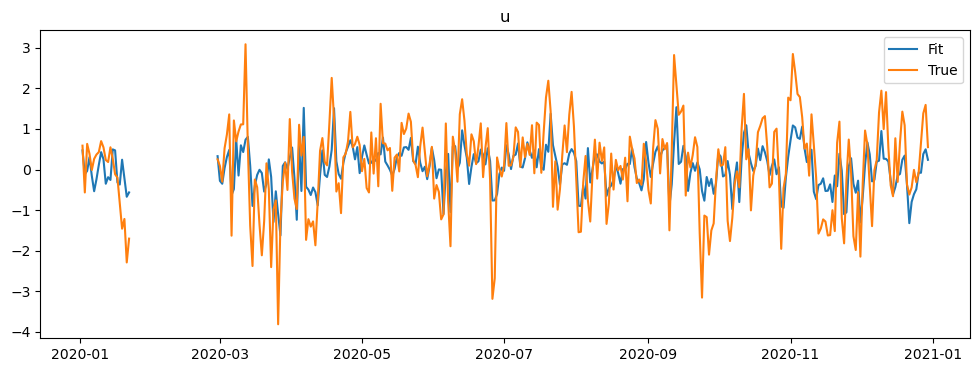

In [15]:
# Verify fit

# Plot last year of fit Middle Weddell

yy = 40
xx = 200

plt.figure(figsize = (12,4))

plt.plot(tt[-365:], u_fit_all[-365:, yy, xx], label = 'Fit')
plt.plot(tt[-365:], u_true_all[-365:, yy, xx], label = 'True')
plt.legend()
plt.title('u')
plt.show()

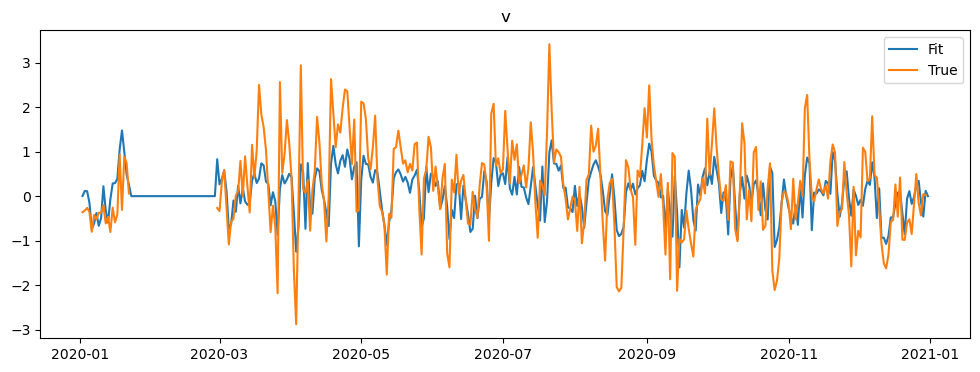

In [16]:
plt.figure(figsize = (12,4))

plt.plot(tt[-365:], v_fit_all[-365:, yy, xx], label = 'Fit')
plt.plot(tt[-365:], v_true_all[-365:, yy, xx], label = 'True')
plt.legend()
plt.title('v')
plt.show()

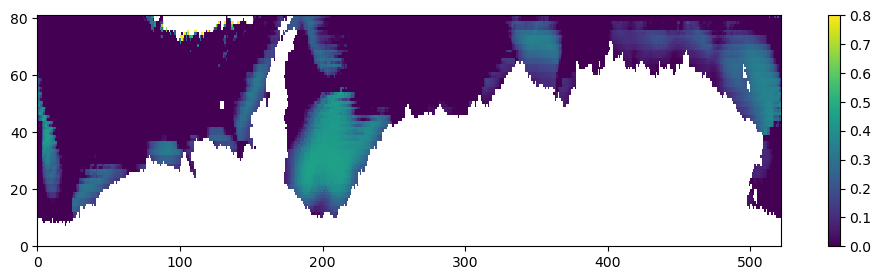

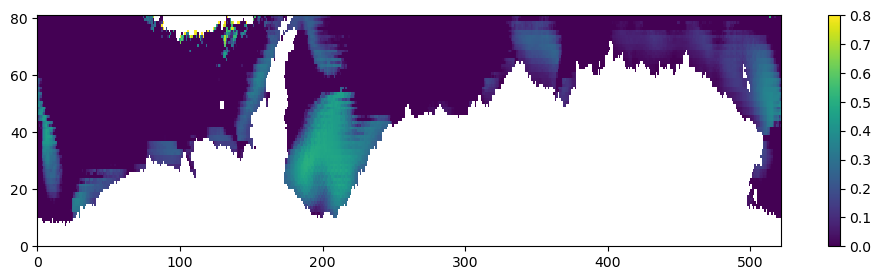

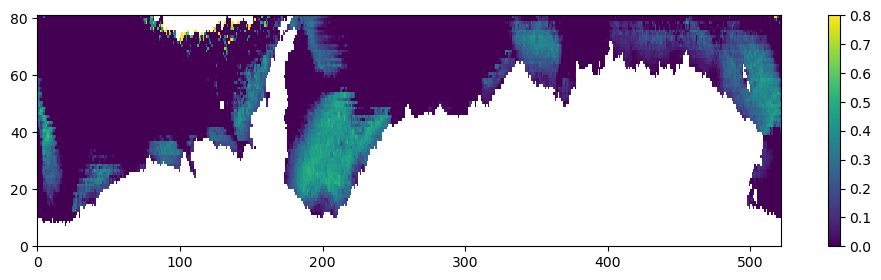

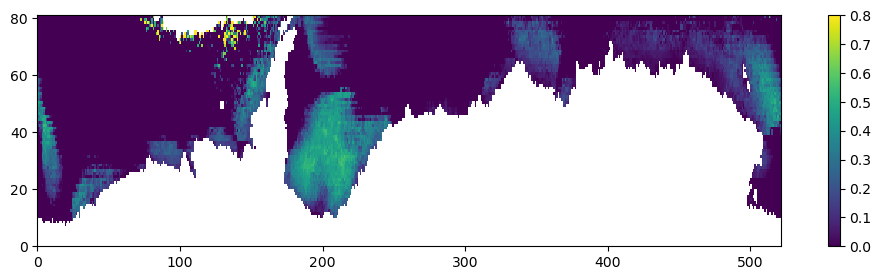

In [19]:
def return_plot_skill(fit, true, r):

    vmin = -1
    vmax = 1
    
    skill_

    plt.figure(figsize = (12,3))
    plt.pcolormesh(skill_u, vmin = vmin, vmax = vmax)
    plt.colorbar()

    plt.figure(figsize = (12,3))
    plt.pcolormesh(skill_v, vmin = vmin, vmax = vmax)
    plt.colorbar()

    plt.figure(figsize = (12,3))
    plt.pcolormesh(skill_w_u, vmin = vmin, vmax = vmax)
    plt.colorbar()

    plt.figure(figsize = (12,3))
    plt.pcolormesh(skill_w_v, vmin = vmin, vmax = vmax)
    plt.colorbar()

### Weighted Skill

In [20]:
# # Initialize arrays 
# u_fit_all = np.zeros((nt, ny, nx))
# v_fit_all = u_fit_all

# u_true_all = np.full((nt, ny, nx), np.nan)
# v_true_all = u_true_all

# m_w_all = np.zeros((3, ny, nx), dtype = complex)

# skill_u = np.full((ny, nx), np.nan)
# skill_v = np.full((ny, nx), np.nan)

# for iy in range(ny):
#     for ix in range(nx):

#         # Skip over land points (all nan)
#         if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
#             u_fit_all[:,iy,ix] = np.nan
#             v_fit_all[:,iy,ix] = np.nan
#             u_true_all[:,iy,ix] = np.nan
#             v_true_all[:,iy,ix] = np.nan
#             m_all[:,iy,ix] = np.nan
            
#         else:
#             try:
                
#                 # Create mask for valid values

#                 # Initialize mask shape of grid to true boolean (1 = True = Inclusion)
#                 true_mask = np.ones_like(uit[:,iy,ix], dtype=bool)

#                 # Set 'True' for indices with nan values, 'False' for valid
#                 inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

#                 # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
#                 true_mask = ~inan

#                 # Filter Ice Motion to true indices
#                 uit_f = uit[true_mask, iy, ix]
#                 vit_f = vit[true_mask, iy, ix]

#                 # Take Wind, Concentration, Uncertainty, time at same indices
#                 uwt_f = uwt[true_mask, iy, ix]
#                 vwt_f = vwt[true_mask, iy, ix]

#                 icy_f = icy[true_mask, iy, ix]

#                 rt_f = rt[true_mask, iy, ix]

#                 # Normalize data

#                 uit_n = normalize(uit_f)
#                 vit_n = normalize(vit_f)
#                 uwt_n = normalize(uwt_f)
#                 vwt_n = normalize(vwt_f)
                
#                 # Save normalized 'true' values
#                 u_true_all[true_mask, iy, ix] = uit_n
#                 v_true_all[true_mask, iy, ix] = vit_n

#                 icy_n = normalize(icy_f)

#                 rt_n = normalize(rt_f)

#                 # Convert to complex
#                 it_c = uit_n + vit_n*1j # Complex Ice Motion Today
#                 wt_c = uwt_n + vwt_n*1j # Complex Wind Today
#                 icy_c = icy_n + icy_n*1j # Complex Previous Day Concentration (imag comp set to 0)

#                 # Define gram matrix
#                 G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

#                 G[:,1] = wt_c # Complex wind, today
#                 G[:,2] = icy_c # Complex ice concentration, yesterday

#                 # Define data matrix
#                 d = it_c.T

#                 rr = 2 * ((rt_n ** 2) + 0.001)
#                 rr = 1 / rr

#                 # Create diagonal matrix of uncertainty
#                 R = np.diag(rr)

#                 print(np.shape(R))

#                 # Weighted model parameters
#                 m_w = (LA.inv(G.T @ R @ G)) @ G.T @ R @ d # (eqn 39, SIOC221B Lec 10)

#                 # Save model parameters
#                 for i in range(len(m)):
#                     m_all[i, iy, ix] = m[i]

#                 # Calculate fit
#                 fit = G @ m_w

#                 # Add nan's back to fit
#                 fit_full = np.full_like(uit[:,iy,ix], np.nan, dtype = complex)
#                 fit_full[true_mask] = fit

#                 u_fit = np.real(fit_full)
#                 v_fit = np.imag(fit_full)

#                 u_fit_all[:,iy,ix] = u_fit
#                 v_fit_all[:,iy,ix] = v_fit
                
#                 rt_n_full = np.full_like(rt[:,iy,ix], np.nan)
#                 rt_n_full[true_mask] = rt_n
        
#                 skill_u[iy,ix] = skill(u_fit, u_true_all[:,iy,ix], rt_n_full)
#                 skill_v[iy,ix] = skill(v_fit, v_true_all[:,iy,ix], rt_n_full)
        
#             except Exception as e:
#                 print(f"Error at iy={iy}, ix={ix}: {e}")

    
#     print(f'iy {iy} complete')

In [21]:
# Initialize arrays 
u_fit_all_wlr = np.zeros((nt, ny, nx))
v_fit_all_wlr = np.zeros((nt, ny, nx))

u_true_all_wlr = np.full((nt, ny, nx), np.nan)
v_true_all_wlr = np.full((nt, ny, nx), np.nan)

skill_w_u_wlr = np.full((ny, nx), np.nan)
skill_w_v_wlr = np.full((ny, nx), np.nan)
skill_u_wlr = np.full((ny, nx), np.nan)
skill_v_wlr = np.full((ny, nx), np.nan)


m_all_wlr = np.zeros((3, ny, nx), dtype = complex)
        

for iy in range(ny):
    for ix in range(nx):

        # Skip over land points (all nan)
        if np.all(np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))):
            u_fit_all[:,iy,ix] = np.nan
            v_fit_all[:,iy,ix] = np.nan
            u_true_all[:,iy,ix] = np.nan
            v_true_all[:,iy,ix] = np.nan
            m_all[:,iy,ix] = np.nan
            
        else:
            try:
                
                # Create mask for valid values

                # Initialize mask shape of grid to true boolean (1 = True = Inclusion)
                true_mask = np.ones_like(uit[:,iy,ix], dtype=bool)

                # Set 'True' for indices with nan values, 'False' for valid
                inan = np.logical_or(np.isnan(uit[:,iy,ix]), np.isnan(vit[:,iy,ix]))

                # Set NaN indices to False (Exclusion) (~ inverts 'True' where nan to 'False')
                true_mask = ~inan

                # Filter Ice Motion to true indices
                uit_f = uit[true_mask, iy, ix]
                vit_f = vit[true_mask, iy, ix]

                # Take Wind, Concentration, Uncertainty, time at same indices
                uwt_f = uwt[true_mask, iy, ix]
                vwt_f = vwt[true_mask, iy, ix]

                icy_f = icy[true_mask, iy, ix]

                rt_f = rt[true_mask, iy, ix]

                # Normalize data

                uit_n = normalize(uit_f)
                vit_n = normalize(vit_f)
                uwt_n = normalize(uwt_f)
                vwt_n = normalize(vwt_f)
                
                # Save normalized 'true' values
                u_true_all_wlr[true_mask, iy, ix] = uit_n
                v_true_all_wlr[true_mask, iy, ix] = vit_n

                icy_n = normalize(icy_f)

                rt_n = normalize(rt_f)
                rt_n = rt_n + 0.001

                # Convert to complex
                it_c = uit_n + vit_n*1j # Complex Ice Motion Today
                wt_c = uwt_n + vwt_n*1j # Complex Wind Today
                icy_c = icy_n + icy_n*1j # Complex Previous Day Concentration (imag comp set to 0)

                # Define gram matrix
                G = np.ones(((len(it_c), 3)), dtype = complex) # first column constant (1)

                G[:,1] = wt_c # Complex wind, today
                G[:,2] = icy_c # Complex ice concentration, yesterday

                # Define data matrix
                d = it_c.T

                rr = 2 * ((rt_n ** 2) + 0.001)
                rr = 1 / rr

                # Create diagonal matrix of uncertainty
                R = np.diag(rr)

                # Weighted model parameters
                m_w = (LA.inv(G.T @ R @ G)) @ G.T @ R @ d # (eqn 39, SIOC221B Lec 10)

                # Find model paremeters
                m = (np.linalg.inv(G.T @ G)) @ G.T @ d

                # Save model parameters
                for i in range(len(m)):
                    m_all_wlr[i, iy, ix] = m[i]

                # Calculate fit
                fit = G @ m

                # Add nan's back to fit
                fit_full = np.full_like(uit[:,iy,ix], np.nan, dtype = complex)
                fit_full[true_mask] = fit

                u_fit = np.real(fit_full)
                v_fit = np.imag(fit_full)

                u_fit_all_wlr[:,iy,ix] = u_fit
                v_fit_all_wlr[:,iy,ix] = v_fit
        
                rt_n_full = np.full_like(rt[:,iy,ix], np.nan)
                rt_n_full[true_mask] = rt_n
        
                skill_u_wlr[iy,ix] = skill(u_fit_all[:,iy,ix], u_true_all[:,iy,ix], rt_n_full)
                skill_v_wlr[iy,ix] = skill(v_fit_all[:,iy,ix], v_true_all[:,iy,ix], rt_n_full)
                
                skill_w_u_wlr[iy,ix] = weighted_skill(u_fit_all[:,iy,ix], u_true_all[:,iy,ix], rt_n_full)
                skill_w_v_wlr[iy,ix] = weighted_skill(v_fit_all[:,iy,ix], v_true_all[:,iy,ix], rt_n_full)
        
        
            except Exception as e:
                print(f"Error at iy={iy}, ix={ix}: {e}")

    
    print(f'iy {iy} complete')

iy 0 complete
iy 1 complete
iy 2 complete
iy 3 complete
iy 4 complete
iy 5 complete
iy 6 complete
iy 7 complete
iy 8 complete
iy 9 complete
iy 10 complete
iy 11 complete
iy 12 complete
iy 13 complete
iy 14 complete
iy 15 complete
iy 16 complete
iy 17 complete
iy 18 complete
iy 19 complete
iy 20 complete
iy 21 complete
iy 22 complete
iy 23 complete
iy 24 complete
iy 25 complete
iy 26 complete
iy 27 complete
iy 28 complete
iy 29 complete
iy 30 complete
iy 31 complete
iy 32 complete
iy 33 complete
iy 34 complete
iy 35 complete
iy 36 complete
iy 37 complete
iy 38 complete
iy 39 complete
iy 40 complete
iy 41 complete
iy 42 complete
iy 43 complete
iy 44 complete
iy 45 complete
iy 46 complete
iy 47 complete
iy 48 complete
iy 49 complete
iy 50 complete
iy 51 complete
iy 52 complete
iy 53 complete
iy 54 complete
iy 55 complete
iy 56 complete
iy 57 complete
iy 58 complete
iy 59 complete
iy 60 complete
iy 61 complete
iy 62 complete
iy 63 complete


KeyboardInterrupt: 

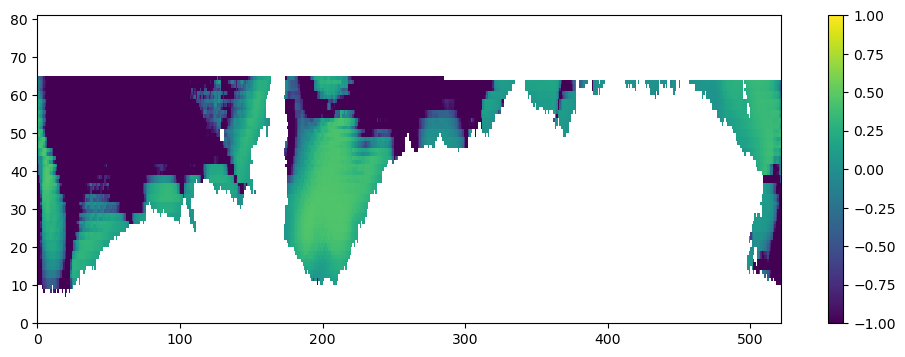

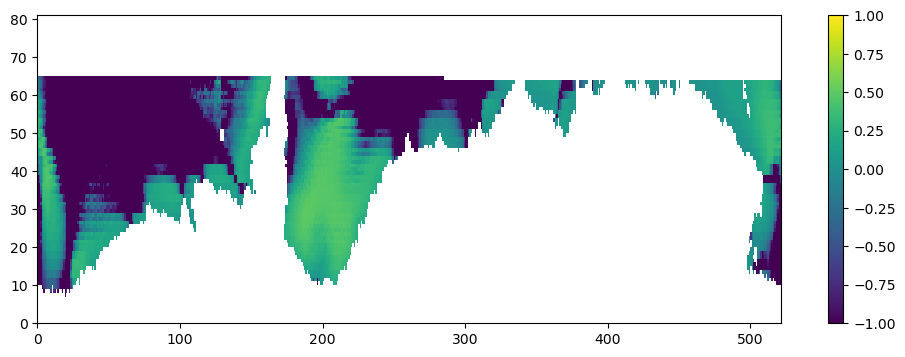

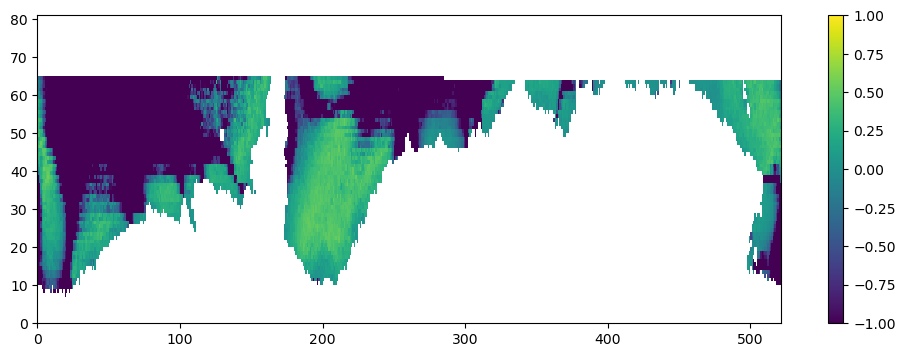

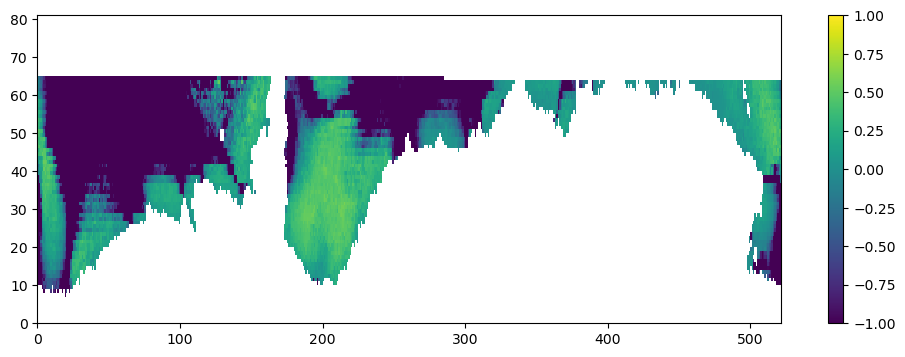

In [24]:
vmin = -1
vmax = 1
cmap = plt.cm.RdBu

plt.figure(figsize = (12,4))
plt.pcolormesh(skill_u_wlr, vmin = vmin, vmax = vmax)
plt.colorbar()

plt.figure(figsize = (12,4))
plt.pcolormesh(skill_v_wlr, vmin = vmin, vmax = vmax)
plt.colorbar()

plt.figure(figsize = (12,4))
plt.pcolormesh(skill_w_u_wlr, vmin = vmin, vmax = vmax)
plt.colorbar()

plt.figure(figsize = (12,4))
plt.pcolormesh(skill_w_v_wlr, vmin = vmin, vmax = vmax)
plt.colorbar()

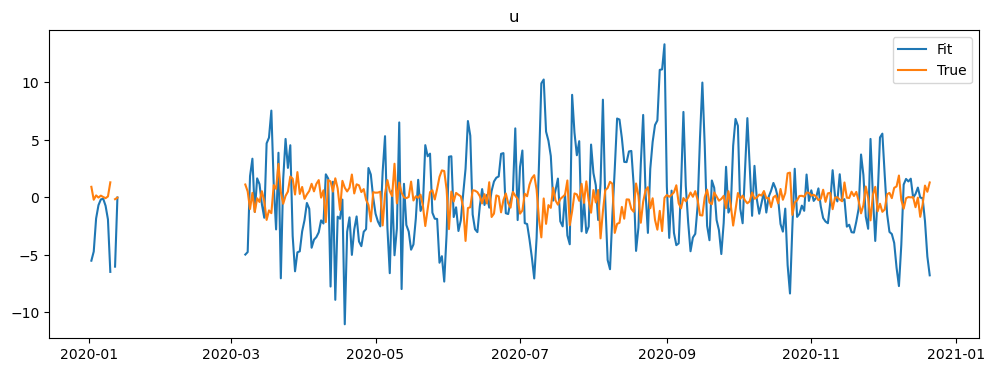

In [25]:
# Verify fit

# Plot last year of fit Middle Weddell

yy = 15
xx = 20

plt.figure(figsize = (12,4))

plt.plot(tt[-365:], u_fit_all_wlr[-365:, yy, xx], label = 'Fit')
plt.plot(tt[-365:], u_true_all_wlr[-365:, yy, xx], label = 'True')
plt.legend()
plt.title('u')
plt.show()